In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# Graphical libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#sklearn modules
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import chi2_contingency
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.svm import SVR
from sklearn.linear_model import Ridge


#progress bar
from tqdm.notebook import tqdm 


from sklearn.model_selection import train_test_split
from sklearn import preprocessing

pd.set_option('display.max_columns', None)

#pd.set_option('display.max_rows', None)

Loading Data

In [2]:
covid_data = pd.read_excel('4analysis_dem_only.xlsx')

In [3]:
covid_data.head()


,country,%_electricity,GDP,GDP_growth,GDP_per_capita,%_population_65+,population,population_growth,population_density,population_65+,%_urban_population,urban_population,area,%_health_expenditure,%_gov_health_expenditure,life_expectancy,infant_mortality,Lat,Long,sum_covid_cases_194weeks,Covid_Cases_per_1000pp
0,Afghanistan,98.713203,1.835388e+10,1.189228,493.750418,2.584927,37172386.0,2.384761,56.93776,960879,25.495,9477100,652860.0,9.395727,0.485975,64.486,48.0,3393911.0,67709953.0,3398434,91.423618
1,Albania,100.000000,1.514702e+10,4.071301,5284.380184,13.744736,2866376.0,-0.246730,104.61230,393976,60.319,1728969,28750.0,5.262714,2.841539,78.458,8.5,411533.0,201683.0,642168,224.034809
2,Algeria,100.000000,1.754057e+11,1.200000,4153.733978,6.362497,42228429.0,2.007374,17.73007,2686782,72.629,30670086,2381740.0,6.218427,4.093853,76.693,20.4,280339.0,16596.0,2710204,64.179608
3,Angola,43.259258,1.013532e+11,-2.003630,3289.646664,2.216374,30809762.0,3.276134,24.71305,682859,65.514,20184707,1246700.0,2.549005,1.068784,60.782,51.9,-112027.0,178739.0,187749,6.093815
4,Antigua and Barbuda,100.000000,1.605352e+09,7.389197,16672.744240,8.799826,96286.0,0.897185,218.83180,8473,24.599,23685,440.0,5.231559,2.904116,76.885,6.0,170608.0,-617964.0,9819,101.977442


In [4]:
# Target = zahl der accumulierten infektionen pro Land pro 100k Einwohner, 193 Tage nach Erstinfektion
# zahl der accumulierten infektionen pro Land pro Einwohner, 193 Tage nach Erstinfektion

# population entfernen? Check
# dasselbe mit deaths

# check r suqared, residuen normal verteilt? 

Exploring Data

In [5]:
covid_data.shape

(160, 21)

In [6]:
covid_data.describe

<bound method NDFrame.describe of                  country  %_electricity           GDP  GDP_growth  \
0            Afghanistan      98.713203  1.835388e+10    1.189228   
1                Albania     100.000000  1.514702e+10    4.071301   
2                Algeria     100.000000  1.754057e+11    1.200000   
3                 Angola      43.259258  1.013532e+11   -2.003630   
4    Antigua and Barbuda     100.000000  1.605352e+09    7.389197   
..                   ...            ...           ...         ...   
155           Uzbekistan     100.000000  5.039261e+10    5.446445   
156            Venezuela     100.000000  9.840000e+10   -0.196000   
157              Vietnam     100.000000  2.452137e+11    7.075789   
158               Zambia      39.812622  2.631214e+10    4.034378   
159             Zimbabwe      41.041584  2.431156e+10    4.829674   

     GDP_per_capita  %_population_65+  population  population_growth  \
0        493.750418          2.584927  37172386.0           2.384

In [7]:
covid_data.dtypes

country                      object
%_electricity               float64
GDP                         float64
GDP_growth                  float64
GDP_per_capita              float64
%_population_65+            float64
population                  float64
population_growth           float64
population_density          float64
population_65+                int64
%_urban_population          float64
urban_population              int64
area                        float64
%_health_expenditure        float64
%_gov_health_expenditure    float64
life_expectancy             float64
infant_mortality            float64
Lat                         float64
Long                        float64
sum_covid_cases_194weeks      int64
Covid_Cases_per_1000pp      float64
dtype: object

In [8]:
covid_data.isna().sum()
covid_data=covid_data.dropna() 

In [9]:
covid_data.shape

(160, 21)

<AxesSubplot:xlabel='GDP_per_capita'>

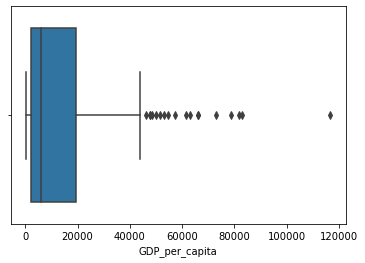

In [10]:
# Checking for ouliers
sns.boxplot(x=covid_data['GDP_per_capita'])


In [11]:
# dealing with outliers

iqr = np.percentile(covid_data['GDP_per_capita'],75) - np.percentile(covid_data['GDP_per_capita'],25)
upper_limit_gdp = np.percentile(covid_data['GDP_per_capita'],75) + 1.5*iqr
lower_limit_gdp = np.percentile(covid_data['GDP_per_capita'],25) - 1.5*iqr


#iqr2 = np.percentile(covid_data['GDP_growth'],75) - np.percentile(covid_data['GDP_growth'],25)
#upper_limit_gdp2 = np.percentile(covid_data['GDP_growth'],75) + 1.5*iqr2
#lower_limit_gdp2 = np.percentile(covid_data['GDP_growth'],25) - 1.5*iqr2


#removing outliers

covid_data = covid_data[(covid_data['GDP_per_capita']>lower_limit_gdp) & (covid_data['GDP_per_capita']<upper_limit_gdp) ]

#& (covid_data['GDP_growth']>lower_limit_gdp2) & (covid_data['GDP_growth']<upper_limit_gdp2)]
                        
                        

In [12]:
covid_data.shape

(142, 21)

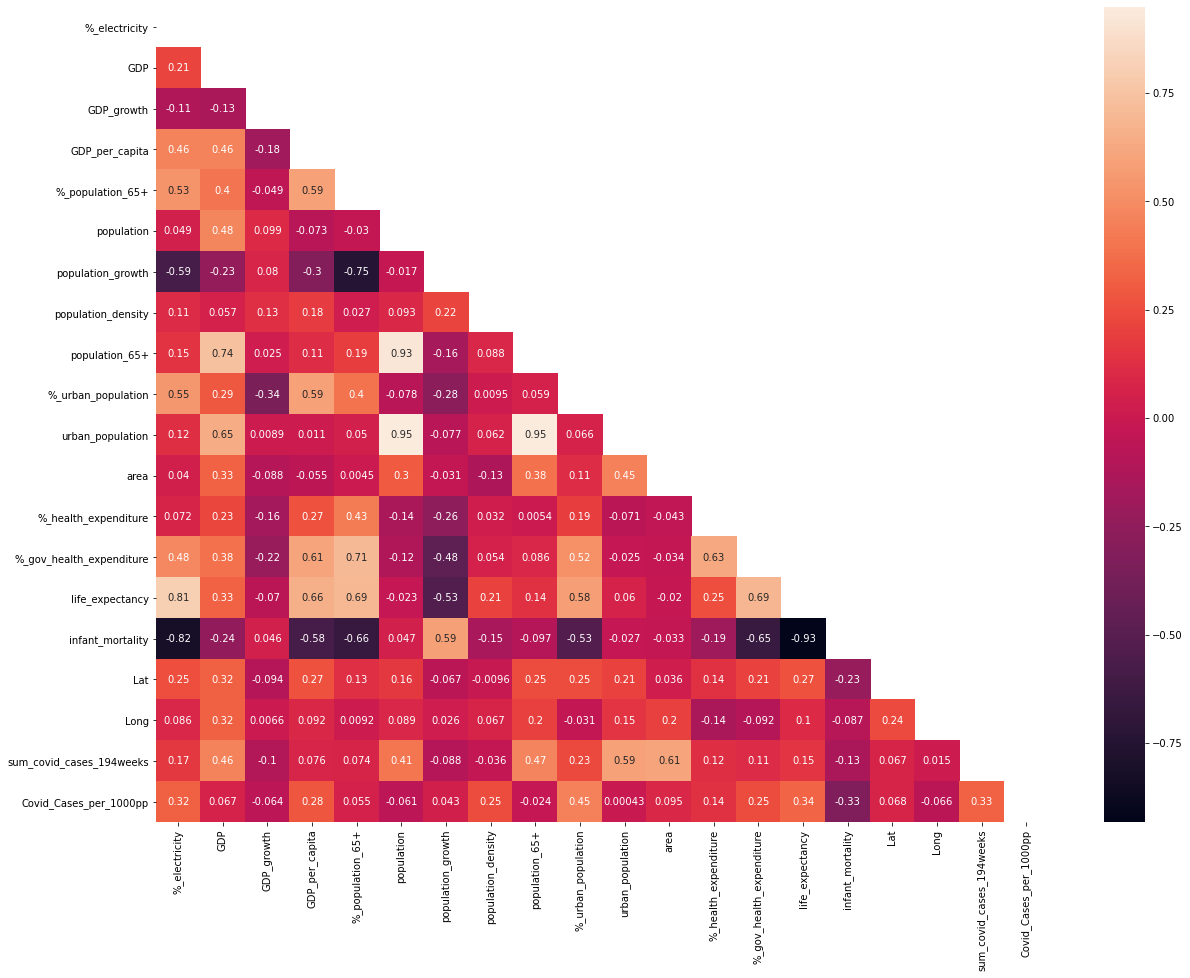

In [13]:
# CHecking Correlation

corr_matrix=covid_data.corr(method='pearson')  # default

mask = np.zeros_like(corr_matrix)
mask[np.triu_indices_from(mask)] = True
fig, ax = plt.subplots(figsize=(20, 15))
ax = sns.heatmap(corr_matrix, mask=mask, annot=True)
#plt.show()

In [357]:
from sklearn.model_selection import train_test_split

y = covid_data['Covid_Cases_per_1000pp']


#X = covid_data.drop(['country','Covid_Cases_per_1000pp','sum_covid_cases_194weeks', 'population_density', 'population_65+','urban_population','area'], axis=1)
# according to spearman

#X = covid_data.drop(['country','Covid_Cases_per_1000pp','sum_covid_cases_194weeks', 'GDP', 'GDP_growth+','%_population_65+','population', 'population_growth', 'population_density', 'population_65+', 'urban_population', 'area', '%_health_expenditure', 'Lat', 'Long'], axis=1)
# according to pearson

X = covid_data.drop(['Covid_Cases_per_1000pp','infant_mortality','%_urban_population','life_expectancy','%_gov_health_expenditure','%_electricity','population_65+', 'country', 'Long','sum_covid_cases_194weeks','urban_population', 'area', 'GDP_growth', 'Lat', 'population_growth', 'GDP', 'population', '%_population_65+', '%_health_expenditure'], axis=1)
#according to p value

#X = covid_data.drop(['country','Covid_Cases_per_1000pp','population_65+', 'sum_covid_cases_194weeks','GDP_growth','GDP','urban_population','population', 'population_density', '%_health_expenditure','life_expectancy','infant_mortality','Lat'], axis=1)

#X = covid_data.drop(['country','Covid_Cases_per_1000pp','population_65+', 'sum_covid_cases_194weeks','GDP_growth','GDP','urban_population','population', 'population_density', '%_health_expenditure','life_expectancy','infant_mortality','Lat'], axis=1)


#X = covid_data.drop(['country','Covid_Cases_per_1000pp','sum_covid_cases_194weeks','%_electricity', 'GDP_growth', '%_population_65+', 'population', 'area', '%_health_expenditure', '%_gov_health_expenditure', 'life_expectancy','infant_mortality', 'Lat', 'cult_pdi','cult_mas','cult_uai', 'cult_ltowvs', 'cult_ivr'   ], axis=1)
#X = covid_data.drop(['Covid_Cases_per_1000pp', 'sum_covid_cases_194weeks','country', 'cult_mas', 'population_density', 'Lat'], axis=1)
#X=covid_data.drop(['country','Covid_Cases_per_1000pp','sum_covid_cases_194weeks','%_electricity', 'GDP_growth', 'population','population_growth','population_density', 'area', '%_health_expenditure', '%_gov_health_expenditure', 'life_expectancy','infant_mortality', 'Lat', 'Long'], axis=1)
#'%_population_65+','%_gov_health_expenditure'
#X = covid_data.drop(['population_density','sum_covid_cases_194weeks', 'Covid_Cases_per_1000pp','sum_covid_cases_194weeks', 'country', 'cult_ltowvs', 'cult_mas'], axis=1)


In [358]:
display(X.head())


,GDP_per_capita,population_density
0,493.750418,56.93776
1,5284.380184,104.61230
2,4153.733978,17.73007
3,3289.646664,24.71305
4,16672.744240,218.83180


In [359]:
X.shape

(142, 2)

## Feature Engineering

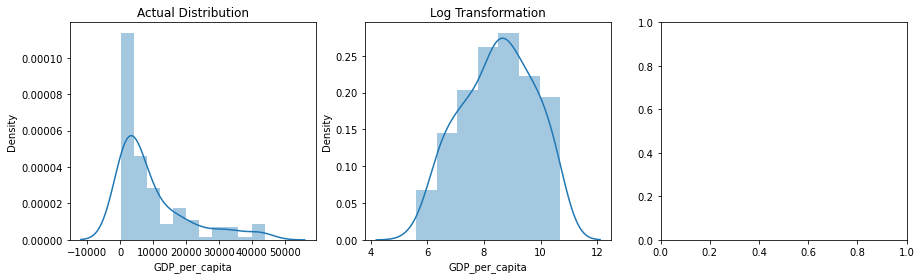

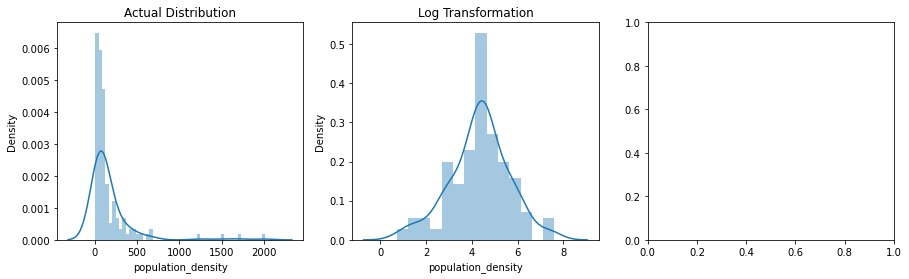

In [360]:
def distribution_plot(data,column):
    data_log = data[column].apply(lambda x: np.log(x) if(x>0) else x)  ## Fix this function to not get infs 
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (15,4))
    sns.distplot(data[column], ax=ax1)
    ax1.set_title('Actual Distribution')
    sns.distplot(data_log, ax=ax2)
    ax2.set_title('Log Transformation')
    plt.show()


for val in X.columns:
     distribution_plot(X,val)

In [366]:
#applying log trans

#X['GDP'] = X['GDP'].apply(lambda x: np.log(x) if(x>0) else x)
X['GDP_per_capita'] = X['GDP_per_capita'].apply(lambda x: np.log(x) if(x>0) else x)
#X['population'] = X['population'].apply(lambda x: np.log(x) if(x>0) else x)
X['population_density'] = X['population_density'].apply(lambda x: np.log(x) if(x>0) else x)
#X['%_urban_population'] = X['%_urban_population'].apply(lambda x: np.log(x) if(x>0) else x)
#X['%_gov_health_expenditure'] = X['%_gov_health_expenditure'].apply(lambda x: np.log(x) if(x>0) else x)

#X['area'] = X['area'].apply(lambda x: np.log(x) if(x>0) else x)
#X['infant_mortality'] = X['infant_mortality'].apply(lambda x: np.log(x) if(x>0) else x)
    #sns.displot(X[val])

In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=9)

standard = StandardScaler()
X_train_scaled = standard.fit_transform(X_train)
X_test_scaled  = standard.transform(X_test)

In [368]:
clf = linear_model.Lasso(alpha=0.1) 
clf.fit(X, y)

Lasso(alpha=0.1)

In [369]:
from sklearn.ensemble import ExtraTreesRegressor

In [370]:
svr_lin = svr_lin = SVR(kernel='linear', C=100, gamma='auto')
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
ridge = Ridge(alpha=1.0)
reg = ExtraTreesRegressor(n_estimators=100, random_state=0).fit(X_train, y_train)

In [371]:
model1 = linear_model.LinearRegression()
model2 = KNeighborsRegressor(7)
model3 = RandomForestRegressor(random_state=0)
model4 = Lasso(alpha=0.1)
model5 = ElasticNet(random_state=0)
#model6 = svr_lin
model7= svr_rbf
model8= ridge    #RidgeRegression
model9 = reg
linear_models = [model1,model2,model3,model4,model5,model7,model8,model9]

In [372]:
def my_scores(lis):
    results = pd.DataFrame(lis,columns = ['R_square','MAE','MSE','RMSE'])
    results.insert(0,'Models',['Linear Regression','KNneighborsRegressor', 'RandomForestRegressor', 'Lasso','ElasticNet','SVR_RBF','RidgeRegression','ExtraTree'])
    results = results.T
    return results

#'''', 'RidgeRegression', 'SVR_RBF', SVR_linear

In [373]:
def models_automation(models, X_train, y_train, X_test, y_test):
    lis = []
    lis1 = []
    for i,model in enumerate(models):
        lis.append([])
        lis1.append([])
        model.fit(X_train, y_train)
        print(f"{str(model)}: Test -> {model.score(X_test, y_test)}")
        lis[i].append(model.score(X_test, y_test))
        y_predict = model.predict(X_test)
        plt.scatter(np.arange(0,len(X_test),1), y_test, color = 'black', label = 'actual')
        plt.plot(np.arange(0,len(X_test),1), y_predict, color = 'blue', linewidth = 3, label = 'predicted')
        plt.title(str(model)+' Test set plot')
        plt.xlabel('Actual')
        plt.ylabel('Predicted')
        plt.legend()
        plt.xticks(())
        plt.yticks(())
        plt.show()
        lis1[i].append(list(y_predict))
        lis[i].append(mean_absolute_error(y_test,y_predict))
        lis[i].append(mean_squared_error(y_test,y_predict))
        lis[i].append(mean_squared_error(y_test, y_predict, squared=False))
    return lis,lis1

LinearRegression(): Test -> -0.010698468231510105


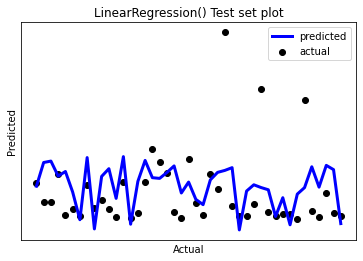

KNeighborsRegressor(n_neighbors=7): Test -> -0.10923080965285314


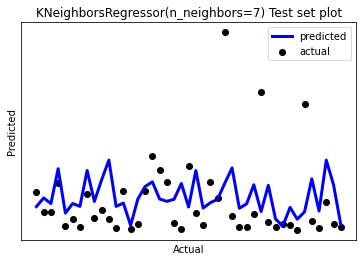

RandomForestRegressor(random_state=0): Test -> -0.11551999176758243


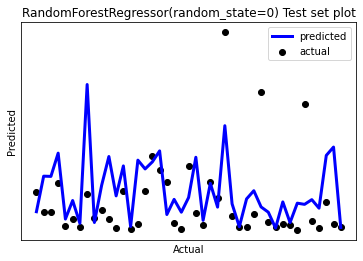

Lasso(alpha=0.1): Test -> -0.009611902507217218


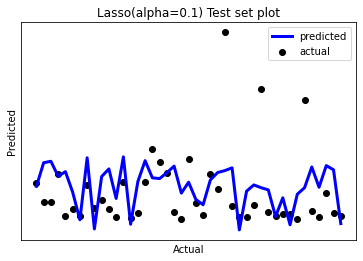

ElasticNet(random_state=0): Test -> -0.018844513342560987


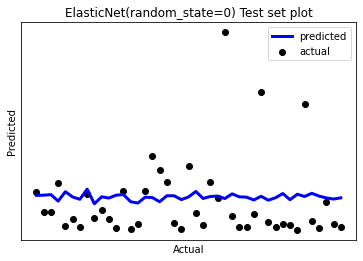

SVR(C=100, gamma=0.1): Test -> -0.11033563930626844


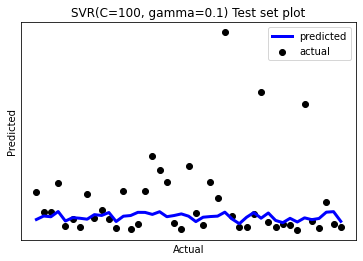

Ridge(): Test -> 0.04335992960755841


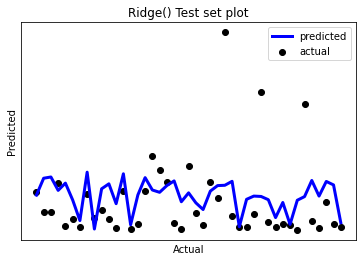

ExtraTreesRegressor(random_state=0): Test -> -0.01784777738726695


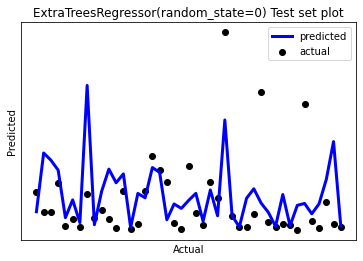

In [374]:
my_list,my_list1 = models_automation(linear_models, X_train, y_train, X_test, y_test)

In [375]:
data1 = my_scores(my_list)
data1.head()

,0,1,2,3,4,5,6,7
Models,Linear Regression,KNneighborsRegressor,RandomForestRegressor,Lasso,ElasticNet,SVR_RBF,RidgeRegression,ExtraTree
R_square,-0.0106985,-0.109231,-0.11552,-0.0096119,-0.0188445,-0.110336,0.0433599,-0.0178478
MAE,249.483,253.065,256.997,249.128,246.646,195.205,233.818,236.023
MSE,117926,129422,130156,117799,118876,129551,111618,118760
RMSE,343.403,359.753,360.772,343.219,344.784,359.932,334.093,344.616


In [376]:
# p values der einzelnen feature mit dem stats model (vorlesung 7.3) wenn p values über 5% rausschmiessen
# anhand der p werte gucken ob die kulturellen daten überhaupt helfen (linear regression von stats dann .summary )
# r suqared und adjusted r squared vergleichen
# bei linear regression residuen angucken (data resources channel) - ist eine lineare regression überhaupt sinnvoll 
# die anderen models verwenden

In [350]:
np.asarray(covid_data)

array([['Afghanistan', 98.7132034301758, 18353881129.88095, ...,
        67709953.0, 3398434, 91.42361752081236],
       ['Albania', 100.0, 15147020535.386873, ..., 201683.0, 642168,
        224.03480911087726],
       ['Algeria', 100.0, 175405660377.3585, ..., 16596.0, 2710204,
        64.17960753406196],
       ...,
       ['Vietnam', 100.0, 245213686369.1568, ..., 108277199.0, 44510,
        0.4658762400971861],
       ['Zambia', 39.8126220703125, 26312140828.640003, ..., 27849332.0,
        808888, 46.61689129821641],
       ['Zimbabwe', 41.0415840148926, 24311560500.0, ..., 29154857.0,
        433940, 30.053290327638624]], dtype=object)

In [351]:
# Feature Elimination Using p-values
import statsmodels.api as sm 

y = covid_data.Covid_Cases_per_1000pp
# Statsmodels.OLS requires us to add a constant.
x = sm.add_constant(x)
model = sm.OLS(y,x)
results = model.fit()
print(results.summary())


                              OLS Regression Results                              
Dep. Variable:     Covid_Cases_per_1000pp   R-squared:                       0.278
Model:                                OLS   Adj. R-squared:                  0.257
Method:                     Least Squares   F-statistic:                     13.18
Date:                    Thu, 11 Mar 2021   Prob (F-statistic):           4.12e-09
Time:                            19:25:16   Log-Likelihood:                -1023.6
No. Observations:                     142   AIC:                             2057.
Df Residuals:                         137   BIC:                             2072.
Df Model:                               4                                         
Covariance Type:                nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------

In [352]:
# as a result of p value check, removig: 'sum_covid_cases_194weeks','%_electricity', 'GDP_growth', 'population','population_growth','population_density', 'area', '%_health_expenditure', '%_gov_health_expenditure', 'life_expectancy','infant_mortality', 'Lat', 'Long'


In [353]:
#sns.pairplot(covid_data)


In [354]:
np.mean(y_test)

243.30749141831743

In [355]:

import math
y_pred_Lasso = model4.predict(X_test) 
MSE = np.square(np.subtract(y_test,y_pred_Lasso)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n Lasso vs Actual")
print(RMSE)

Root Mean Square Error:
 Lasso vs Actual
341.9933730364366


In [356]:
y_pred_ExtraTree = model9.predict(X_test) 
MSE = np.square(np.subtract(y_test,y_pred_ExtraTree)).mean() 
 
RMSE = math.sqrt(MSE)
print("Root Mean Square Error:\n Lasso vs Actual")
print(RMSE)

Root Mean Square Error:
 Lasso vs Actual
442.257404360168
